In [1]:
from pandas import *
import sys
path = '/Users/jplotkin/Dropbox/school/adv_ml'
path += '/project/scripts_notebooks'
sys.path.append(path)

from prep_datasets import *
from train_cv_predict import *
plt.style.use('ggplot')

%load_ext autotime
%load_ext autoreload
%matplotlib inline
%autoreload 2

### Load data
* image features from CNN
* metadata

In [2]:
data_path = '../boots_dataset/'
metadata_women = read_csv(data_path + 'boots_aws_metadata_160405.csv',
                         index_col = 'asin')
metadata_women = metadata_women[metadata_women.sex == 'women']
features_women = read_csv(data_path + 'features_women.csv',
                         index_col = 'asin')

time: 3.53 s


In [3]:
path = '/Users/jplotkin/Dropbox/school/adv_ml/'
path += 'project/ImageRec/data/test_likes_josh.txt'
likes_dislikes = read_csv(path, 
                 header = None)\
                    .drop_duplicates()\
                    .set_index(0, inplace = False)
likes_dislikes.index.name = 'asin'
likes_dislikes.columns = ['like']

time: 26.1 ms


In [4]:
likes_dislikes.merge(metadata_women, left_index = True, 
                    right_index = True).merge(features_women, left_index = True, 
                           right_index = True).like.value_counts()

0    127
1     33
Name: like, dtype: int64

time: 44.2 ms


In [5]:
likes = likes_dislikes.merge(metadata_women, left_index = True, 
                    right_index = True).merge(features_women, left_index = True, 
                           right_index = True).like

time: 37.9 ms


### PrepData class
* balance dataset by oversampling
* perform stratified sampling to split data
* takes list of size of training set (the rest go into test)
* creates a feature set of unlabeled data (for recommendations)

In [6]:
dataset = PrepData(DataFrame(likes), features_women, 
                   [10, 25, 50, 80], 5, True)

10 0.9375
10 150
10 150
10 150
10 150
10 150
25 0.84375
25 135
25 135
25 135
25 135
25 135
50 0.6875
50 110
50 110
50 110
50 110
50 110
80 0.5
80 80
80 80
80 80
80 80
80 80
time: 17.7 s


In [7]:
dataset.training_sets[50][0].like.value_counts()

1    50
0    40
Name: like, dtype: int64

time: 21.4 ms


In [8]:
dataset.training_sets[50][0].drop_duplicates().like.value_counts()

0    40
1    10
Name: like, dtype: int64

time: 383 ms


In [9]:
dataset.test_sets[50][0].like.value_counts()

0    87
1    23
Name: like, dtype: int64

time: 22.2 ms


In [10]:
dataset.test_sets[50][0].drop_duplicates().like.value_counts()

0    87
1    23
Name: like, dtype: int64

time: 240 ms


In [11]:
asin_in = []
for asin in dataset.test_sets[50][0].index:
    asin_in.append(asin in dataset.training_sets[50][0])
print sum(asin_in)

0
time: 18.7 ms


### TrainModel class
TrainModel(train, test, algo, grid params, nfolds)
* performs grid search automatically using params and number of folds
* returns best model
* include methods to get AUC, plot ROC, and show top n recommendations
* TODO: implement XGBoost grid search 

In [12]:
training_set = dataset.training_sets[80][0]
test_set = dataset.test_sets[80][0]
unlabeled = dataset.unlabeled

time: 20.6 ms


### XGBoost:

[0]	train-auc:0.999023
[1]	train-auc:1.000000
[2]	train-auc:1.000000
[3]	train-auc:1.000000
[4]	train-auc:1.000000
[5]	train-auc:1.000000
[6]	train-auc:1.000000
[7]	train-auc:1.000000
[8]	train-auc:1.000000
[9]	train-auc:1.000000


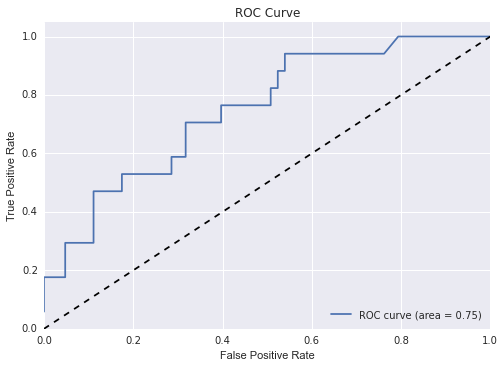

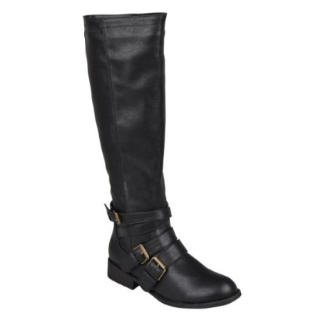

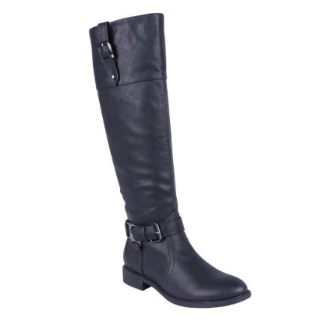

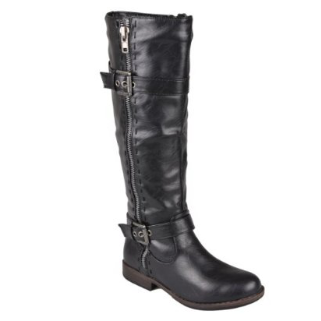

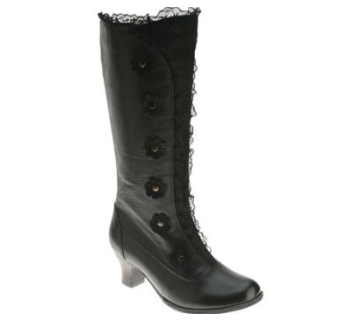

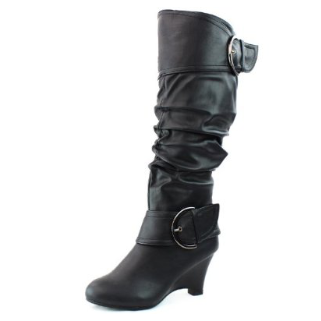

time: 2.14 s


In [24]:
param = {'bst:max_depth':150, 
         'bst:eta':0.3, 
         'silent':1,
         'objective':'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['eval_metric'] = ['auc']
model = TrainModel(training_set.copy(), test_set.copy(), 
                   'xgb_no_cv', param, 5)
model.get_auc()
model.plot_roc()
model.display_recommendations(unlabeled.copy(), 5)

In [25]:
import operator
importance = model.model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
importance_df = DataFrame(importance, columns=['feature', 'fscore'])
importance_df['fscore'] = \
    importance_df['fscore'] / importance_df['fscore'].sum()
important_features = importance_df\
            .sort_values('fscore', ascending = False)\
            .iloc[:5, :].values
        
standardized = unlabeled.copy()
for c in standardized.columns:
    standardized.loc[:, c] = (standardized.loc[:, c] -
                              standardized.loc[:, c].mean()) \
                             / standardized.loc[:, c].std()        

time: 2.24 s


In [ ]:
def display_images(asin, n):
    img = '../boots_dataset/pics_boots/{0}.jpg'.format(asin)
    if os.path.isfile(img) and open(img).read() != '':
        ax = fig.add_subplot(2,4,n)
        ax.grid(False)
        for label in ax.get_xticklines():
            label.set_visible(False)
        for label in ax.get_yticklines():
            label.set_visible(False)
        for label in ax.get_xticklabels():
            label.set_visible(False)
        for label in ax.get_yticklabels():
            label.set_visible(False)  

        ax.imshow(mpimg.imread(img))
        return True
    else:
        # skip if the image is not found
        return False

time: 28.3 ms


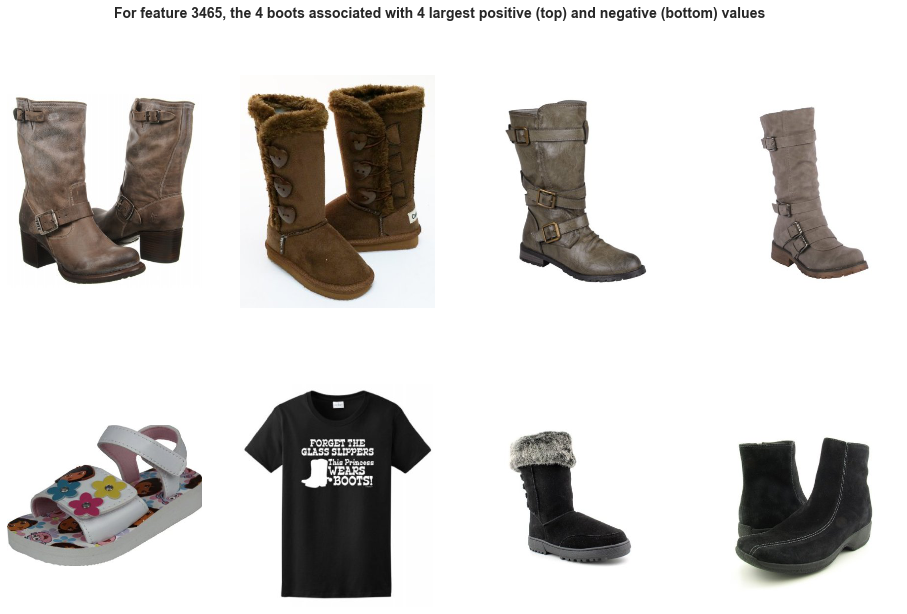

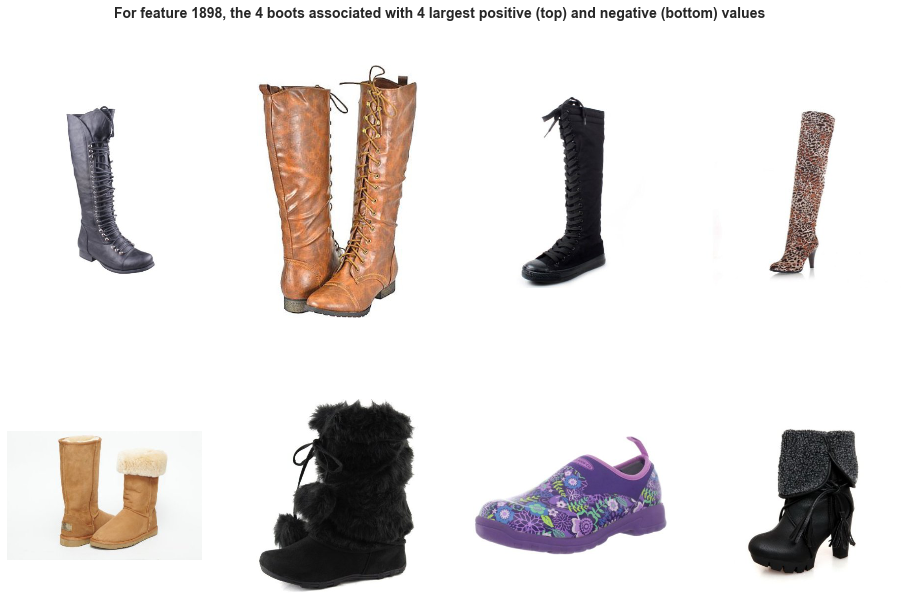

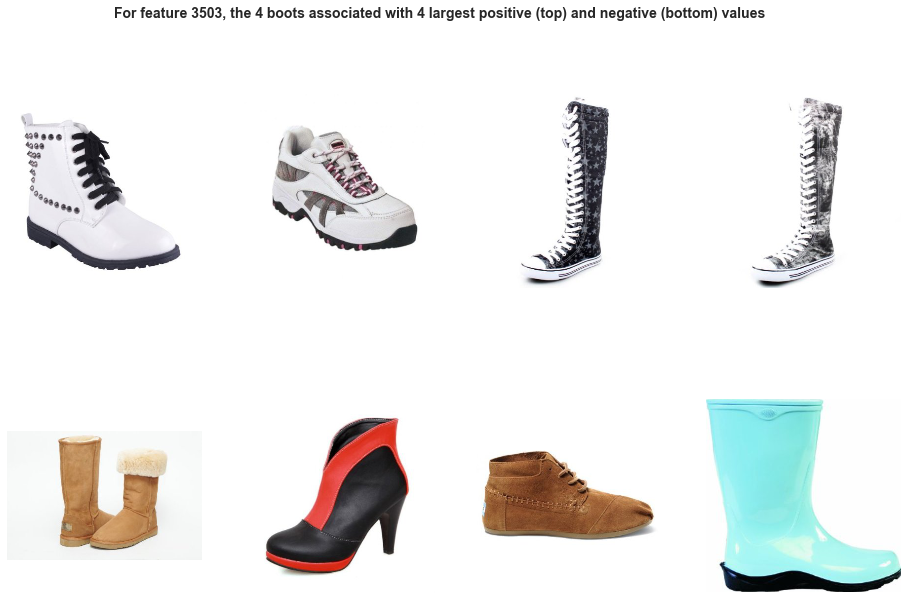

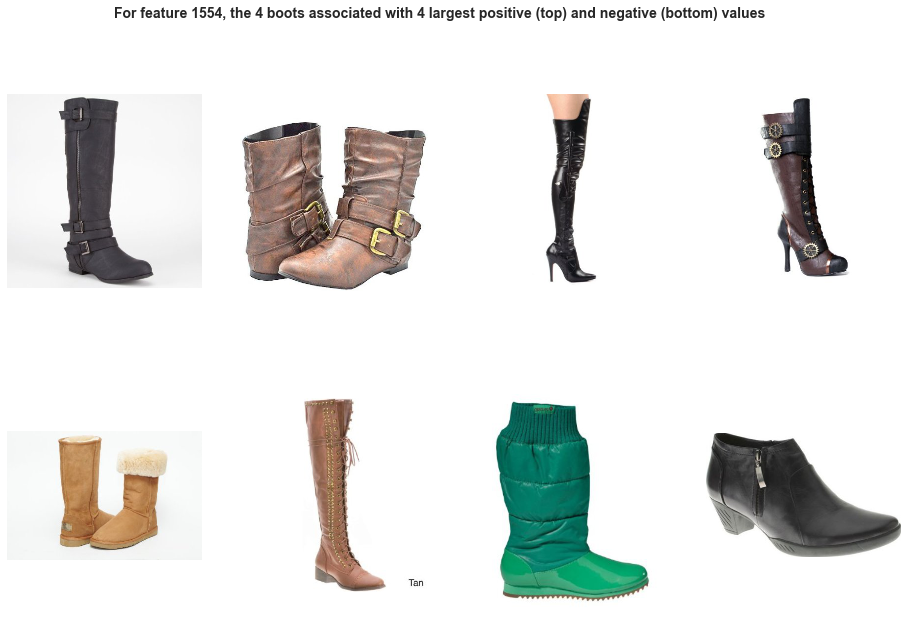

In [ ]:
import seaborn as sns
for feature in [f[0] for f in important_features]:
    order = standardized.sort_values(by = str(feature),
                                    ascending = False)\
                        .index
        
    with sns.axes_style("white"):    
        fig = plt.figure(figsize = (16,10))
        title = 'For feature {0}, '.format(feature)
        title += 'the 4 boots associated with 4 largest positive (top) '
        title += 'and negative (bottom) values'
        plt.suptitle(title, fontsize = 14, fontweight = 'bold') 

    loc = 1
    for top_bottom in [1, -1]:
        n = 1
        while n <= 4:
            found = display_images(order[n*top_bottom], loc)
            if found == True:
                n += 1
                loc += 1
            # skip over this image if it can't be found
            else:
                pass
        
    plt.savefig('features_{0}.jpg'.format(feature))
    plt.show()

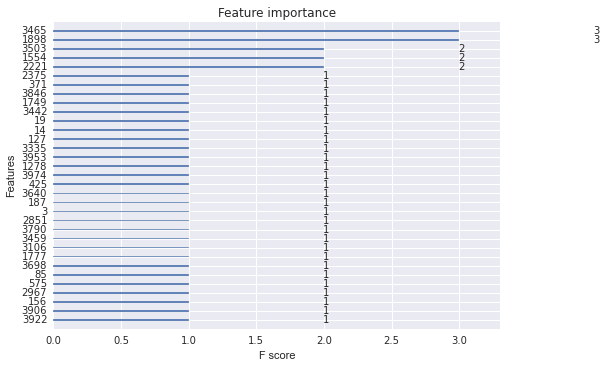

time: 477 ms


In [18]:
xgb.plot_importance(model.model)

In [275]:
# param = {
#     'num_boost_round': [100, 250, 500],
#     'eta': [0.05, 0.1, 0.3, 1],
#     'max_depth': [2, 6, 9, 12],
#     'subsample': [0.9, 1.0],
#     'colsample_bytree': [0.9, 1.0],
# }

# # param = {
# #     'num_boost_round': [100],
# #     'eta': [1],
# #     'max_depth': [2],
# #     'subsample': [0.9],
# #     'colsample_bytree': [0.9],
# # }
# param = {'bst:eta': [1],
#          'bst:max_depth': [2],
#          'eval_metric': ['auc'],
#          'nthread': [4],
#          'objective': ['binary:logistic'],
#          'silent': [1]}

# model = TrainModel(training_set.copy(), test_set.copy(), 
#                    'xgb', param, 5)
# print model.get_auc()
# model.plot_roc()

time: 21.3 ms


In [276]:
# model.model.fit(training_set.drop('like', axis = 1), training_set.like)
# model.display_recommendations(unlabeled.copy(), 10)

time: 19.8 ms


In [277]:
# import operator
# importance = model.model.clf.get_fscore()
# importance = sorted(importance.items(), key=operator.itemgetter(1))
# importance_df = DataFrame(importance, columns=['feature', 'fscore'])
# importance_df['fscore'] = \
#     importance_df['fscore'] / importance_df['fscore'].sum()
# important_features = importance_df\
#             .sort_values('fscore', ascending = False)\
#             .iloc[:5, :].values

time: 20.3 ms


In [278]:
# standardized = unlabeled.copy()
# for c in standardized.columns:
#     standardized.loc[:, c] = (standardized.loc[:, c] -
#                               standardized.loc[:, c].mean()) \
#                              / standardized.loc[:, c].std()

time: 19.8 ms


In [279]:
# def display_images(asin, n):
#     if os.path.isfile(img) and open(img).read() != '':
#         ax = fig.add_subplot(2,4,n)
#         img = '../boots_dataset/pics_boots/{0}.jpg'.format(asin)

#         ax.grid(False)
#         for label in ax.get_xticklines():
#             label.set_visible(False)
#         for label in ax.get_yticklines():
#             label.set_visible(False)
#         for label in ax.get_xticklabels():
#             label.set_visible(False)
#         for label in ax.get_yticklabels():
#             label.set_visible(False)  

#         ax.imshow(mpimg.imread(img))
#         return True
#     else:
#         # skip if the image is not found
#         return False

time: 20.9 ms


In [280]:
# for feature in [f[0] for f in important_features]:
#     order = standardized.sort_values(by = str(feature),
#                                     ascending = False)\
#                         .index
        
#     with sns.axes_style("white"):    
#         fig = plt.figure(figsize = (16,10))
#         title = 'For feature {0}, '.format(feature)
#         title += 'the 4 boots associated with 4 largest positive (top) '
#         title += 'and negative (bottom) values'
#         plt.suptitle(title, fontsize = 14, fontweight = 'bold') 

#     n = 1
#     for top_bottom in [1, -1]: 
#         while n not in [5, 9]:
#             found = display_images(order[n*top_bottom], n)
#             if found == True:
#                 n += 1
#             # skip over this image if it can't be found
#             else:
#                 pass
        
#     plt.savefig('features_{0}.jpg'.format(feature))
#     plt.show()

time: 20.9 ms


In [ ]:
# important_features = importance_df\
#             .sort_values('fscore', ascending = False)\
#             .iloc[:5, :].values

In [19]:
# param = {'bst:max_depth': 2, 
#          'bst:eta': 1, 
#          'bst:min'
#          'silent':1,
#          'objective':'binary:logistic' }
# param['nthread'] = 4
# param['eval_metric'] = 'auc'
# param['eval_metric'] = ['auc']#, 'ams@0'] 

# model = TrainModel(training_set.copy(), test_set.copy(), 'xgb', param, 5)
# model.get_auc()
# model.plot_roc()
# model.display_recommendations(unlabeled.copy(), 5)

time: 19.7 ms


### SVM:

In [16]:
param_grid = [
  {'C': [10**i for i in np.arange(-7,2,.1)], 
       'kernel': ['linear']},
  {'C': [10**i for i in np.arange(-7,2,.1)], 
       'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

svm = TrainModel(training_set.copy(), test_set.copy(), 
                   'svm', param_grid, 10)

time: 4min 29s


0.5
Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'kernel': 'rbf', 'C': 0.39810717055347578, 'gamma': 0.001}

Model with rank: 2
Mean validation score: 1.000 (std: 0.000)
Parameters: {'kernel': 'rbf', 'C': 0.50118723362724482, 'gamma': 0.001}

Model with rank: 3
Mean validation score: 1.000 (std: 0.000)
Parameters: {'kernel': 'rbf', 'C': 0.63095734448015817, 'gamma': 0.001}



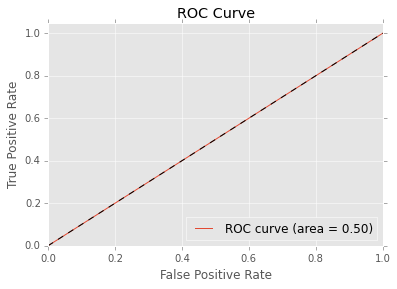

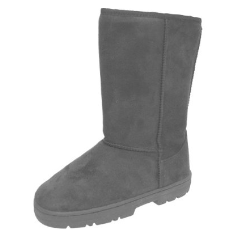

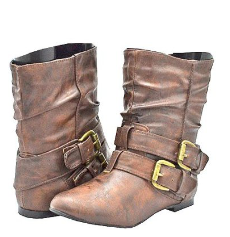

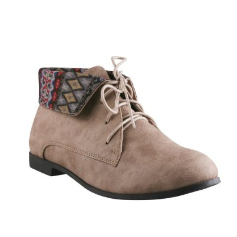

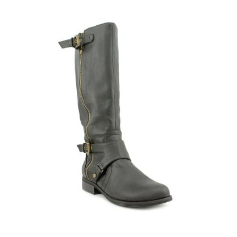

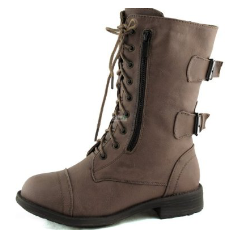

time: 2.57 s


In [17]:
print svm.get_auc()
svm.report()
svm.plot_roc()

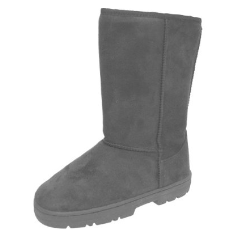

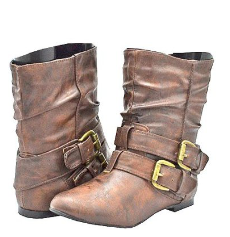

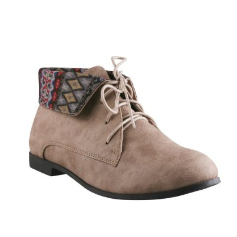

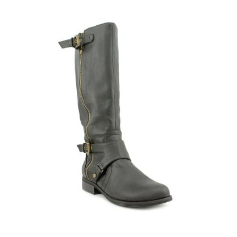

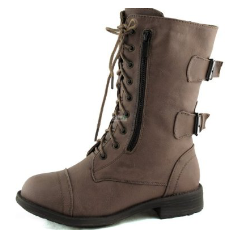

time: 1.07 s


In [39]:
svm.model.fit(training_set.drop('like', axis = 1), training_set.like)
svm.display_recommendations(unlabeled.copy(), 10)

### Naive Bayes

In [18]:
param_grid = [
  {'alpha': [10**i for i in np.arange(-7,2,.1)]}
 ]    
nb = TrainModel(training_set.copy(), test_set.copy(),
                   'nb', param_grid, 10)

time: 5.14 s


Model with rank: 1
Mean validation score: 0.993 (std: 0.014)
Parameters: {'alpha': 9.9999999999999995e-08}

Model with rank: 2
Mean validation score: 0.993 (std: 0.014)
Parameters: {'alpha': 1.2589254117941662e-07}

Model with rank: 3
Mean validation score: 0.993 (std: 0.014)
Parameters: {'alpha': 1.5848931924611109e-07}



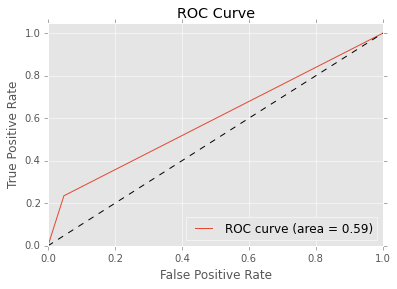

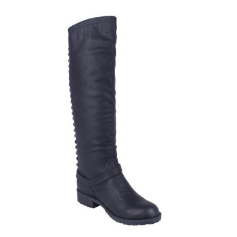

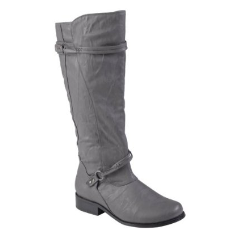

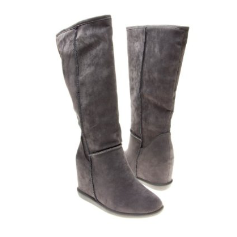

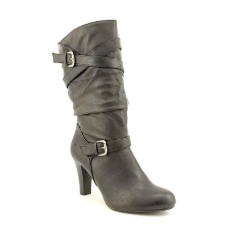

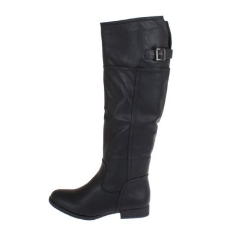

time: 1.37 s


In [19]:
nb.get_auc()
nb.report()
nb.plot_roc()

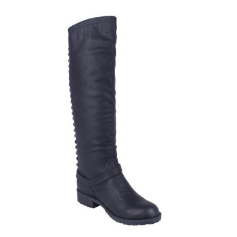

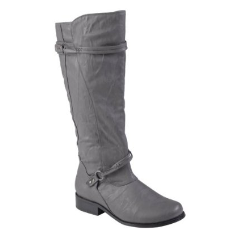

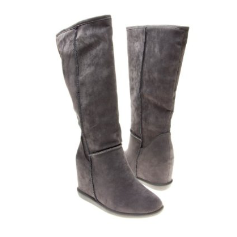

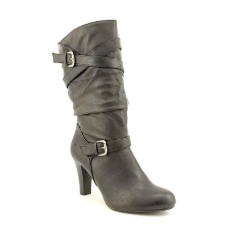

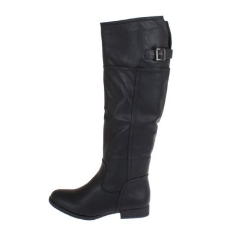

time: 542 ms


In [38]:
nb.model.fit(training_set.drop('like', axis = 1), training_set.like)
nb.display_recommendations(unlabeled.copy(), 10)

### Random Forest

In [20]:
param_grid = {"max_depth": [3, 4000],
              "max_features": np.arange(1,4000,200),
              "min_samples_split": np.arange(1,500,100),
              "min_samples_leaf": [100, 50, 25, 10, 5],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rf = TrainModel(training_set.copy(), test_set.copy(),
                   'rf', param_grid, 10)

time: 2min 54s


Model with rank: 1
Mean validation score: 0.972 (std: 0.026)
Parameters: {'bootstrap': True, 'min_samples_leaf': 5, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 3001, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.972 (std: 0.026)
Parameters: {'bootstrap': True, 'min_samples_leaf': 5, 'min_samples_split': 1, 'criterion': 'entropy', 'max_features': 3001, 'max_depth': 4000}

Model with rank: 3
Mean validation score: 0.972 (std: 0.026)
Parameters: {'bootstrap': False, 'min_samples_leaf': 5, 'min_samples_split': 1, 'criterion': 'entropy', 'max_features': 201, 'max_depth': 4000}



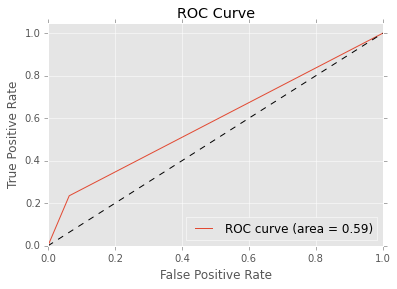

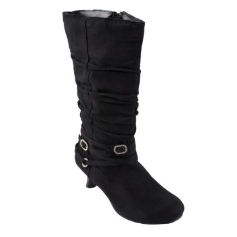

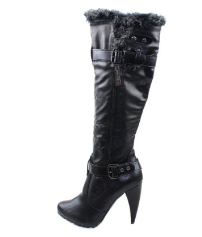

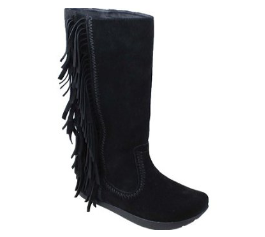

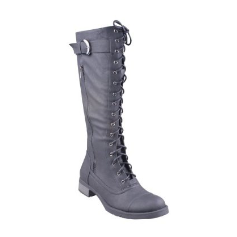

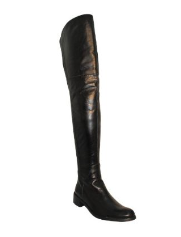

time: 1.11 s


In [21]:
rf.get_auc()
rf.report()
rf.plot_roc()

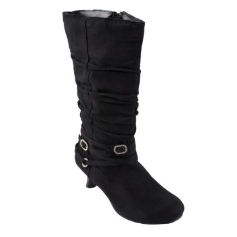

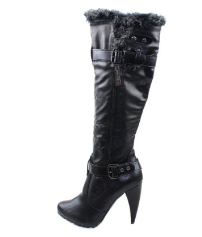

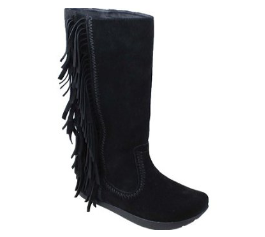

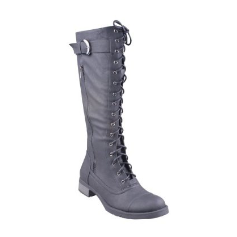

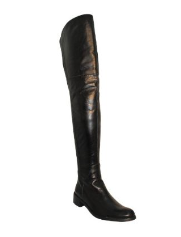

time: 487 ms


In [37]:
rf.model.fit(training_set.drop('like', axis = 1), training_set.like)
rf.display_recommendations(unlabeled.copy(), 10)

### Elastic Net logistic regression

Model with rank: 1
Mean validation score: 0.688 (std: 0.116)
Parameters: {'alpha': 0.099999999999995093, 'l1_ratio': 1.0}

Model with rank: 2
Mean validation score: 0.653 (std: 0.100)
Parameters: {'alpha': 0.0031622776601682627, 'l1_ratio': 1.0}

Model with rank: 3
Mean validation score: 0.653 (std: 0.182)
Parameters: {'alpha': 1.258925411794094, 'l1_ratio': 0.90000000000000002}



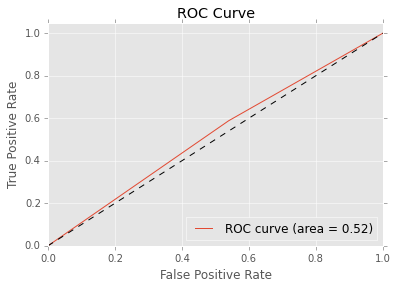

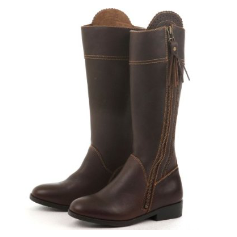

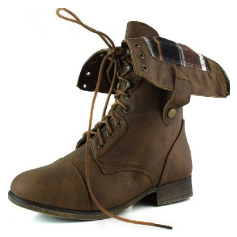

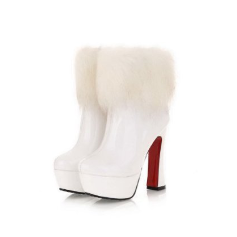

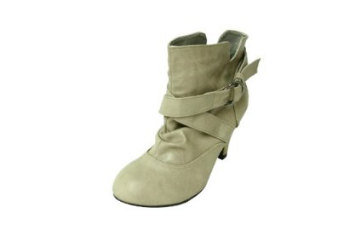

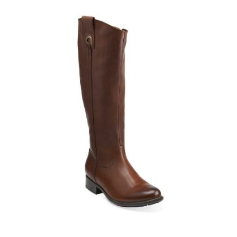

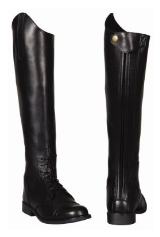

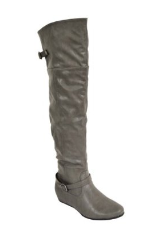

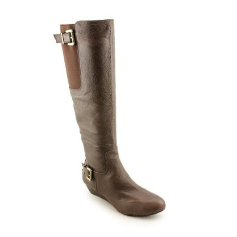

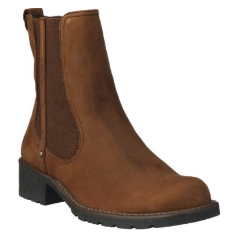

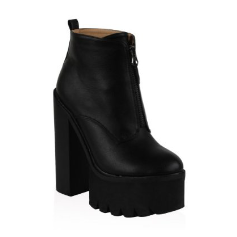

time: 2min 11s


In [33]:
param_grid = [
        {'alpha': [10**i for i in np.arange(-7,2,.1)], 
         'l1_ratio': np.arange(0,1.1,0.1)
        }]

enet = TrainModel(training_set.copy(), test_set.copy(),
                   'lr_enet', param_grid, 2)
enet.get_auc()
enet.report()
enet.plot_roc()

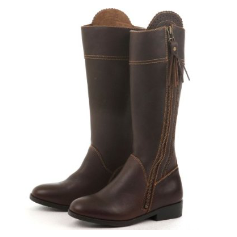

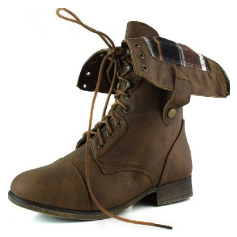

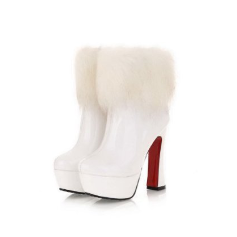

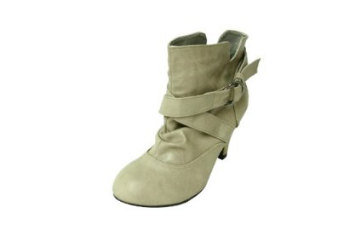

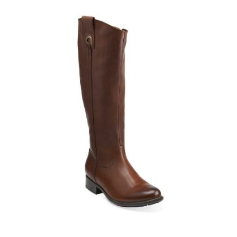

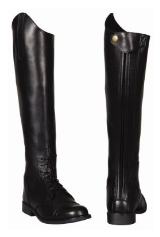

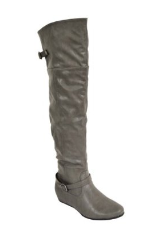

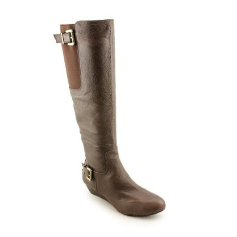

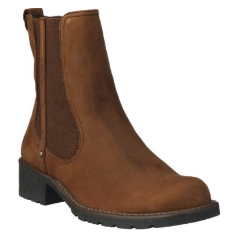

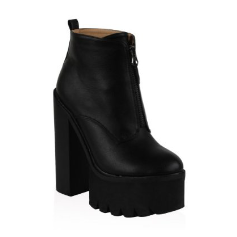

time: 1.03 s


In [34]:
enet.model.fit(training_set.drop('like', axis = 1), training_set.like)
enet.display_recommendations(unlabeled.copy(), 10)

### Scikit-learn SGD Classifier

Model with rank: 1
Mean validation score: 0.993 (std: 0.014)
Parameters: {'alpha': 1.9952623149688747e-07, 'loss': 'log', 'l1_ratio': 0.70000000000000007}

Model with rank: 2
Mean validation score: 0.993 (std: 0.014)
Parameters: {'alpha': 7.9432823472426269e-05, 'loss': 'hinge', 'l1_ratio': 0.90000000000000002}

Model with rank: 3
Mean validation score: 0.993 (std: 0.014)
Parameters: {'alpha': 0.00099999999999996728, 'loss': 'hinge', 'l1_ratio': 0.90000000000000002}



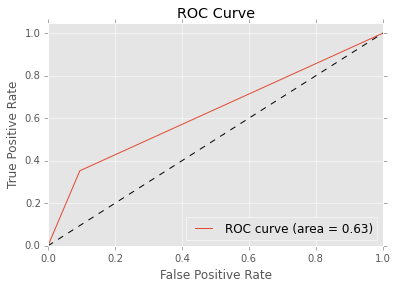

time: 7min 48s


In [35]:
param_grid = [
        {'alpha': [10**i for i in np.arange(-7,2,.1)], 
         'l1_ratio': np.arange(0,1.1,0.1),
         'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
        }]

sgd = TrainModel(training_set.copy(), test_set.copy(),
                   'sgd', param_grid, 2)
sgd.get_auc()
sgd.report()
sgd.plot_roc()

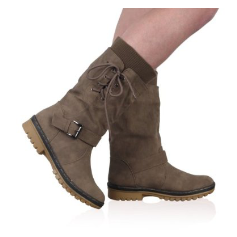

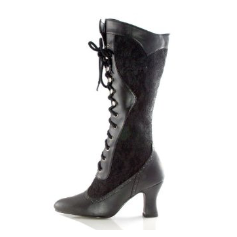

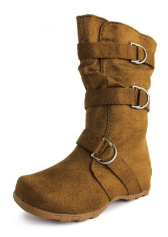

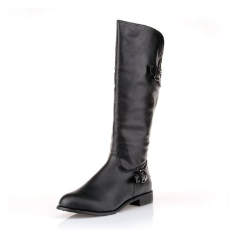

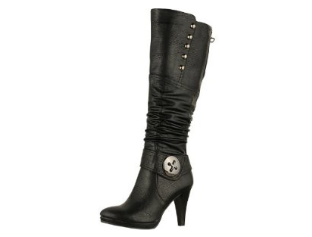

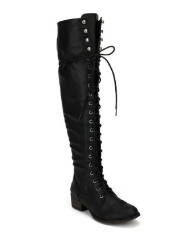

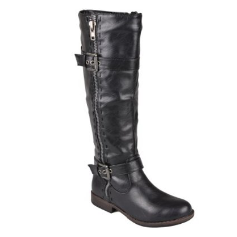

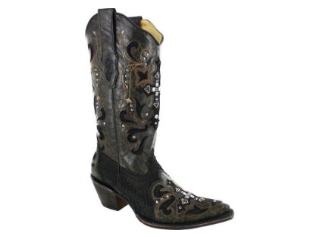

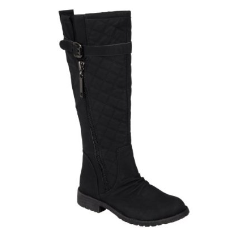

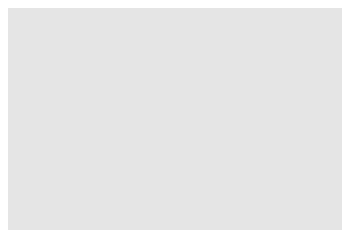

time: 1.3 s


In [36]:
sgd.model.fit(training_set.drop('like', axis = 1), training_set.like)
sgd.display_recommendations(unlabeled.copy(), 10)